In [13]:
# Math librarys
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Library for workign with excel
import xlsxwriter
import xlrd

# Librarys for IBM devices
from qiskit import *
from qiskit import IBMQ, assemble, transpile
from qiskit.providers.ibmq import least_busy

# Librarys for working with qiskit
from qiskit import Aer, QuantumCircuit, QuantumRegister, execute
from qiskit.opflow import Z, I, StateFn
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitSampler, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from typing import Union
from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

# Load the IBM Account
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q')

ibmqfactory.load_account:WARNING:2022-04-18 13:14:19,702: Credentials are already in use. The existing account in the session will be replaced.


In [14]:
# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend("statevector_simulator"))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

# define smallest devices to find least busy backend
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits <= 1
                                   and not x.configuration().simulator)

# create a QNN instance with a real quantum processor 
backend = least_busy(small_devices)
print(backend)

ba_sv   = Aer.get_backend('statevector_simulator')
ba_qasm = Aer.get_backend('qasm_simulator')
ba_real = backend

ibmq_armonk


In [15]:
# callback function that draws a live plot of the loss function and gets called by the training method
def callback_training(training_value, max_learning_step, learning_step):
    clear_output(wait=True)
    training_funct_vals.append(training_value)
    plt.title("RMSE during the trainig")
    plt.xlabel("Learning step")
    plt.ylabel("Loss function value")
    plt.plot(range(len(training_funct_vals)), training_funct_vals)
    if (max_learning_step-1) == learning_step:
        # safe callback plots as image
        plt.savefig('Training process from Experiment {}.png'.format(experiment))
    plt.show()

    
# Function to evaluate the expectation value of the quantum circuit. 
# The expectaton value represents the output of the QNN, with respect to
# a specific set of weights, an input x and an observable Z
def pool_circuits(weights,X):
    qc_list = []
        
    for x_ in X:
        weights_dict = weights[:]                                         
        weights_dict.append(x_)
    
        qc_exp = quantum_circuit.assign_parameters(weights_dict, inplace=False)
        qc_list.append(qc_exp)
        
    return qc_list

                
def calc_exp(qc_list_calc):
     
    exp_val_list = []
    statistics = [0.0,0.0]
    number_runs = math.ceil((len(qc_list_calc)/100))
    
    cut_qc_list = [qc_list_calc[i:i+100] for i in range(0, len(qc_list_calc), 100)] 
        
    for qc_list in cut_qc_list:

        job = execute(qc_list_calc, backend_multi, shots = 250)
        results = job.result()
    
        for circuit in qc_list:
        
            try:
                statistics = [results.get_counts(circuit)['0'],results.get_counts(circuit)['1']]
            except KeyError as e:
                if e.args[0] == '0':
                    statistics[0] = 0
                elif e.args[0] == '1':
                    statistics[1] = 1
                else:
                    raise ValueError('Hier stimmt was nicht!')
      
            probabilities = [statistics[0]/250,statistics[1]/250] 
            expectation = probabilities[0]*1+probabilities[1]*(-1)
            exp_val_list.append(expectation)
    
    return exp_val_list

def calc_exp_grad(qc_list_calc):
     
    exp_val_list = []
    qc_list_grad = []
    statistics = [0.0,0.0]
    
    for w in qc_list_calc:
        for circuit in w:
            qc_list_grad.append(circuit)  
            
    number_runs = math.ceil((len(qc_list_grad)/100))
    
    cut_qc_list = [qc_list_grad[i:i+100] for i in range(0, len(qc_list_grad), 100)]
    
    for qc_list in cut_qc_list: 
        job = execute(qc_list, backend_multi, shots = 250)
        results = job.result()
    
        for circuit in qc_list:
            try:
                statistics = [results.get_counts(circuit)['0'],results.get_counts(circuit)['1']]
            except KeyError as e:
                if e.args[0] == '0':
                    statistics[0] = 0
                elif e.args[0] == '1':
                    statistics[1] = 1
                else:
                    raise ValueError('Hier stimmt was nicht!')
      
            probabilities = [statistics[0]/250,statistics[1]/250] 
            expectation = probabilities[0]*1+probabilities[1]*(-1)
            exp_val_list.append(expectation)
    
    return exp_val_list
    
# Function to evaluate the finite difference gradient of a weight of the QNN
def evaluate_grad_finit_diff(weights):    
      
    grad_weights = []
    gradients_list = []
    predictions=[]
    grad_circuits=[]
    loss_list=[]
    loss = 0
    batch_list=[]
    y_batch_list=[]
        
    for w in range(len(weights)):
        # shift the QNN parameter (weight) of the given index by +- eps
        plus = weights[:]
        minus = weights[:]
        plus[w] += eps
        minus[w] -= eps
        grad_weights.append(plus)
        grad_weights.append(minus)
    
    # check, wether the batch size is smaller then the number of total learning examples
    if size_batch>num_samples:
        raise ValueError('Batch size is bigger then the number of learning examples!')
    
    for w in grad_weights:
        # form a batch of learning values, randomly picked out of X_learn 
        batch_indices = random.sample(range(0, X_learn.size-1), size_batch)
        batch = [X_learn[l] for l in batch_indices]
        y_batch = [y_learn[k] for k in batch_indices]
        batch_list.append(batch)
        y_batch_list.append(y_batch)
        grad_circuits.append(pool_circuits(w,batch))
    
    predictions = calc_exp_grad(grad_circuits)
    cut_predictions = [predictions[i:i+size_batch] for i in range(0, len(predictions), size_batch)]      
    
    for w,yb in zip(cut_predictions,y_batch_list):
        # calculate the loss with the quadratic difference function
        for t, p in zip(yb, w):
            loss = loss + (p - t) ** 2
        loss = 0.5*(loss / len(batch))
        loss_list.append(loss)
    
    iterations = list(range(0,len(loss_list),2))
    for l in iterations:
        gradient = (loss_list[l]-loss_list[l+1]) / (2* eps)
        gradients_list.append(gradient)
    
    # evaluate and return the finit difference gradient
    return gradients_list


# Calculate the RMSE of the QNN with respect to all the learning data 
def root_square_loss(weights):
    loss = 0
    predictions=[]
    # calculate the output of the QNN with the given weights for every input data in X_learn      
    circ_predictions = pool_circuits(weights,X_learn)
    predictions = calc_exp(circ_predictions)
    # sum up the squared difference between QNN predictions and the learning output y_learn    
    for t, p in zip(y_learn, predictions):
        loss = loss + (p - t) ** 2
    loss = loss / len(y_learn)
    return np.sqrt(loss)

# Calculate the RMSE of the QNN with respect to the apply data 
def extra_root_square_loss(weights):
    loss = 0
    predictions=[]
    # calculate the output of the QNN with the given weights for every input data in X_learn      
    circ_predictions = pool_circuits(weights,X_apply)
    predictions = calc_exp(circ_predictions)
    # sum up the squared difference between QNN predictions and the learning output y_learn    
    for t, p in zip(y_apply, predictions):
        loss = loss + (p - t) ** 2
    loss = loss / len(y_learn)
    return np.sqrt(loss)



# Calculate the loss function using stochastic batch learning 
def loss_function(weights):
    loss = 0
    predictions=[]
    
    # check, wether the batch size is smaller then the number of total learning examples
    if size_batch>num_samples:
        raise ValueError('Batch size is bigger then the number of learning examples!')
    
    # form a batch of learning values, randomly picked out of X_learn 
    batch_indices = random.sample(range(0, X_learn.size-1), size_batch)
    batch = [X_learn[l] for l in batch_indices]
    y_batch = [y_learn[k] for k in batch_indices]
    
    predictions = calc
    # calculate the loss with the quadratic difference function
    for t, p in zip(y_batch, predictions):
        loss = loss + (p - t) ** 2
    loss = loss / len(batch)
    return 0.5*loss


def train_network(weights):
    # Prepare the lists and arrays for training
    weights_training = weights                                                # take the starting weights from the function argument 
    gradients = []                                                            # list for gradients
    delta = np.full(len(weights), 0.0)                                        # list for the updates of the weights
    X_learning_steps = np.full([learning_steps], range(learning_steps))       # list with the leaning steps
    RMSE_training = np.full([learning_steps], 0.0)                            # list for the RMSE after every training step

    # Train the weights
    for j in range(learning_steps):
        gradients = evaluate_grad_finit_diff(weights_training)
        for k in range(len(weights_training)):
            delta[k] = -gradients[k]*learning_rate
            weights_training[k] += delta[k]
        RMSE_training[j] = root_square_loss(weights_training,)                 # calculate the RMSE after every learning step
        callback_training(RMSE_training[j],learning_steps,j)                   # call the function to plot the RMSE
          
    return weights_training

# Function for adding a S-Gate to the quantum circuit of the QNN
def S(x, quantum_circuit):
    "Add a data encoding circuit block to the circuit."
    quantum_circuit.ry(scaling*x, 0)

# Function for adding an U-Gate to the quantum circuit of the QNN
def W(theta, quantum_circuit):
    """Trainable circuit block."""
    quantum_circuit.u(theta[0], theta[1], theta[2], 0)

# Function for creating the quantum circuit that represents the QNN
def serial_quantum_model(r):
    
    qc = QuantumCircuit(1)
    
    # first, delete all gates on quantum circuit instance
    if(qc.num_qubits!=0):
        while qc.depth() > 0:
            qc.data.pop(-1)
    
    # create the parameter list for the circuit
    param_input = Parameter('x')
    params_weight = [ [ None for y in range(3) ] for x in range( r+1 ) ]
    
    for i in range(r+1):
        string_theta1 = 'theta1.{}'.format(i)
        string_theta2 = 'theta2.{}'.format(i)
        string_theta3 = 'theta3.{}'.format(i)
        params_weight[i][0] = Parameter(string_theta1)
        params_weight[i][1] = Parameter(string_theta2)
        params_weight[i][2] = Parameter(string_theta3)
    
    # add the S- and U-gates to the quantum circuit
    for l in range(r):
        W(params_weight[l], qc)
        S(param_input, qc)
        
    # L+1'th unitary
    W(params_weight[r], qc)
    qc.measure_all()
    
    return qc

In [16]:
def create_training_data(function):
    
    global num_samples
    global x_learn_min
    global x_learn_max
    global x_apply_min
    global x_apply_max
    global X_ 
    global X_2
    global scaling
    global f
    global X_learn
    global X_apply
    global y_learn
    global y_apply
    
    
    ## Anzahl Lern- und Testdatenpunkte ##
    num_samples = 50

    ## LERNBEREICH ## 
    x_learn_min = -np.pi
    x_learn_max = np.pi

    ## ANWENDUNGSBEREICH ##
    x_apply_min = -6
    x_apply_max = 6

    X_ = np.linspace(x_learn_min, x_learn_max, num=50)
    X_2 = np.linspace(x_apply_min, x_apply_max, num=50)

    if function == "sinus":
        ## Sinus ##
        scaling = 1
        f = lambda x: np.sin(x)

    elif function == "gauß":
        ## Glockenkurve ##
        scaling = 1
        f = lambda x: (2/np.exp(0.4*x**2))-1

    elif function == "linear":
        ## Gerade ##
        scaling = 0.5
        f = lambda x: x/np.pi

    elif function == "polynom":
        ## Polynom ##
        scaling = 0.5
        f = lambda x: ((-0.072*x**5+0.133*x**4+2.102*x**3-6.404*x**2+6.49*x-1.7)*(1/78))+0.9
    
    else:
        raise ValueErrro('Bitte eine gültige Funktionsklasse angeben: "sinus", "gauß", "linear", "polynom"')
        
    X_learn = np.fromstring(trainingdata[counter_experiments].get('X_learn'), dtype=float, sep=',')
    X_apply = np.fromstring(trainingdata[counter_experiments].get('X_apply'), dtype=float, sep=',')
    y_learn = np.fromstring(trainingdata[counter_experiments].get('y_learn'), dtype=float, sep=',')
    y_apply = np.fromstring(trainingdata[counter_experiments].get('y_apply'), dtype=float, sep=',')
    xlsx_X_learn.append(','.join(str(e) for e in X_learn))
    xlsx_X_apply.append(','.join(str(e) for e in X_apply))
    xlsx_y_learn.append(','.join(str(e) for e in y_learn))
    xlsx_y_apply.append(','.join(str(e) for e in y_apply))
 
   
    # plot the target function and the training data
    plt.plot(X_, f(X_), "r--")
    plt.plot(X_learn, y_learn, "bo")
    plt.show()
    
    return 0

def prepare_experiments():
    # Prepare the lists for writing the experiment results into an excel file
    global xlsx_experiment
    global xlsx_RMSE_notraining
    global xlsx_RMSE_aftertraining
    global xlsx_RMSE_extra
    global xlsx_eps
    global xlsx_learning_rate 
    global xlsx_learning_steps
    global xlsx_batch_size
    global xlsx_starting_weights
    global xlsx_opt_weights
    global xlsx_backend_name
    global xlsx_backend_version
    global xlsx_backend_update
    global xlsx_X_learn 
    global xlsx_X_apply
    global xlsx_y_learn
    global xlsx_y_apply
    
    xlsx_experiment = []
    xlsx_RMSE_notraining = []
    xlsx_RMSE_aftertraining = []
    xlsx_RMSE_extra = []
    xlsx_eps = []
    xlsx_learning_rate = []
    xlsx_learning_steps =[]
    xlsx_batch_size = []
    xlsx_starting_weights= []
    xlsx_opt_weights = []
    xlsx_backend_name = []
    xlsx_backend_version = []
    xlsx_backend_update = []
    xlsx_X_learn = []
    xlsx_X_apply = []
    xlsx_y_learn = []
    xlsx_y_apply = []
     
    return 0
    
def start_experiment():
    global name_exp
    global backend_properties
    global starting_weights
    global RMSE_notraining 
    
    # Parameters of experiment
    name_exp = 'Results (Simulator) from Experiment {}.txt'.format(experiment)
    xlsx_experiment.append(experiment)
    backend_properties = backend.properties()
    xlsx_backend_name.append(backend_properties.backend_name)
    xlsx_backend_version.append(backend_properties.backend_version)
    xlsx_backend_update.append(backend_properties.last_update_date)

    # choosing starting weights randomly and write them into a file
    starting_weights = [float(s) for s in trainingdata[counter_experiments].get('Starting weights').split(',')] 
    xlsx_starting_weights.append(','.join(str(e) for e in starting_weights))

    #calculate RMSE
    RMSE_notraining = root_square_loss(starting_weights)
    print('RMSE_notraining: ', RMSE_notraining)
    xlsx_RMSE_notraining.append(RMSE_notraining)

    # plot network-function without training
    y_notraining = calc_exp(pool_circuits(starting_weights,X_))
    plt.plot(X_, y_notraining, "r-")
    plt.savefig('RMSE (no training) from Experiment {}.png'.format(experiment))
    plt.show()
    
    return 0

def end_experiment():
    RMSE_aftertraining = root_square_loss(opt_weights)
    xlsx_RMSE_aftertraining.append(RMSE_aftertraining)
    print('Final loss: ', RMSE_aftertraining)
    
    RMSE_extra = extra_root_square_loss(opt_weights)
    xlsx_RMSE_extra.append(RMSE_extra)
    print('Loss in Extrapolation: ', RMSE_extra)

    # plot target function
    plt.plot(X_, f(X_), "r--")

    # plot data
    plt.plot(X_learn, y_learn, "bo")

    # plot fitted line
    #Netzwerkfunktion
    y_NN = calc_exp(pool_circuits(opt_weights,X_))
    plot = plt.plot(X_, y_NN, "g-")
    plt.savefig('Model after training from Experiment {}.png'.format(experiment))
    plt.show(plot)
       
def read_excel_file():
    global trainingdata
    trainingdata =[]
    
    workbook_read = xlrd.open_workbook('C:\\Users\\User\Documents\\Studium\\Masterstudium Industrial Management Ulm\\Masterarbeit\\Programming\\FinalProgramms\\Experiments\\Experiment Daten Simulator\\Gesamtergebnisse Experimente Quantenprozessor NEU.xls')
    worksheet_read = workbook_read.sheet_by_index(0)
    first_row = [] # The row where we stock the name of the column
    for col in range(worksheet_read.ncols):
        first_row.append( worksheet_read.cell_value(0,col) )
        # tronsform the workbook to a list of dictionnary
    for row in range(1, worksheet_read.nrows):
        elm = {}
        for col in range(worksheet_read.ncols):
            elm[first_row[col]]=worksheet_read.cell_value(row,col)
        trainingdata.append(elm)

    return 0
        
def print_excel_file():
    # Create an new Excel file and add a worksheet.
    workbook = xlsxwriter.Workbook('Results Experiments.xlsx', {'remove_timezone': True})
    worksheet = workbook.add_worksheet()

    # Widen the columns to make the text clearer.
    worksheet.set_column('A:A', 10)
    worksheet.set_column('B:B', 17)
    worksheet.set_column('C:C', 17)
    worksheet.set_column('D:D', 17)
    worksheet.set_column('E:E', 10)
    worksheet.set_column('F:F', 10)
    worksheet.set_column('G:G', 10)
    worksheet.set_column('H:H', 12)
    worksheet.set_column('I:I', 18)
    worksheet.set_column('J:J', 20)
    worksheet.set_column('K:K', 17)
    worksheet.set_column('L:L', 17)
    worksheet.set_column('M:M', 22)
    worksheet.set_column('N:N', 12)
    worksheet.set_column('O:O', 12)
    worksheet.set_column('P:P', 12)
    worksheet.set_column('Q:Q', 12)
    
    # Add a bold and center format to use to highlight and align cells.
    center = workbook.add_format()
    center.set_align('center')
    bold_center = workbook.add_format({'bold': True})
    bold_center.set_align('center')
    

    # Write some simple text.
    worksheet.write('A2', 'Experiment', bold_center)
    worksheet.write('B2', 'RMSE no training',bold_center)
    worksheet.write('C2', 'RMSE after training', bold_center)
    worksheet.write('D2', 'RMSE extrapolation', bold_center)
    worksheet.write('E1', 'Trainingsdaten',bold_center )
    worksheet.write('E2', 'eps', center)
    worksheet.write('F2', 'Lernrate', center)
    worksheet.write('G2', 'Lernschritte', center)
    worksheet.write('H2', 'Batch-Größe', center)
    worksheet.write('I2', 'Starting weights',bold_center)
    worksheet.write('J2', 'Weights after training', bold_center)
    worksheet.write('K2', 'Name Q-Prozessor', bold_center)
    worksheet.write('L2', 'Version Q-Prozessor', bold_center)
    worksheet.write('M2', 'Letztes Update Prozessor', bold_center)
    worksheet.write('N2', 'X_learn', bold_center)
    worksheet.write('O2', 'X_apply', bold_center)
    worksheet.write('P2', 'y_learn', bold_center)
    worksheet.write('Q2', 'y_apply', bold_center)
    

    for row_num, data in enumerate(xlsx_experiment):
        worksheet.write(row_num+2, 0, data)

    for row_num, data in enumerate(xlsx_RMSE_notraining):
        worksheet.write(row_num+2, 1, data)
    
    for row_num, data in enumerate(xlsx_RMSE_aftertraining):
        worksheet.write(row_num+2, 2, data)
        
    for row_num, data in enumerate(xlsx_RMSE_extra):
        worksheet.write(row_num+2, 3, data)
    
    for row_num, data in enumerate(xlsx_eps):
        worksheet.write(row_num+2, 4, data)
    
    for row_num, data in enumerate(xlsx_learning_rate):
        worksheet.write(row_num+2, 5, data)
    
    for row_num, data in enumerate(xlsx_learning_steps):
        worksheet.write(row_num+2, 6, data)
    
    for row_num, data in enumerate(xlsx_batch_size):
        worksheet.write(row_num+2, 7, data)
    
    for row_num, data in enumerate(xlsx_starting_weights):
        worksheet.write(row_num+2, 8, data)
    
    for row_num, data in enumerate(xlsx_opt_weights):
        worksheet.write(row_num+2, 9, data)
    
    for row_num, data in enumerate(xlsx_backend_name):
        worksheet.write(row_num+2, 10, data)
    
    for row_num, data in enumerate(xlsx_backend_version):
        worksheet.write(row_num+2, 11, data)
    
    for row_num, data in enumerate(xlsx_backend_update):
        worksheet.write(row_num+2, 12, data)
        
    for row_num, data in enumerate(xlsx_X_learn):
        worksheet.write(row_num+2, 13, data)
    
    for row_num, data in enumerate(xlsx_X_apply):
        worksheet.write(row_num+2, 14, data)
    
    for row_num, data in enumerate(xlsx_y_learn):
        worksheet.write(row_num+2, 15, data)
    
    for row_num, data in enumerate(xlsx_y_apply):
        worksheet.write(row_num+2, 16, data)    

    workbook.close()

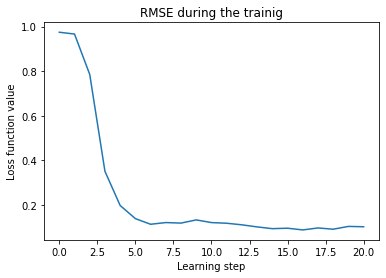

Final loss:  0.09805945529463403
Loss in Extrapolation:  0.37076874505279744


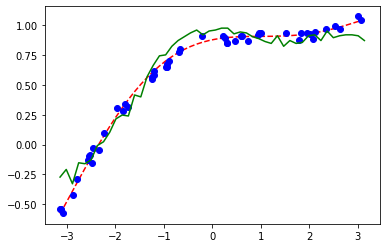

In [17]:
# choose, which Quantum Instance will be used to calculate expectation values:
#ba_sv   = state vector based evaluation (no noise)
#ba_qasm = simulator based evaluation (noise simulation)
#ba_real = execution on real quantum processor
backend_multi = ba_sv

# circuit parameters
r = 3 # number of times the encoding gets repeated (here equal to the number of layers)

read_excel_file()

num_experiments = int(len(trainingdata))
experiment = 1

prepare_experiments()

for i in range(num_experiments):
    
    counter_experiments = i
    # Training parameters
    eps = trainingdata[i].get('eps')                             # parameter for the Gradients
    learning_rate = trainingdata[i].get('Lernrate')              # learning rate for the weights of the network
    learning_steps = int(trainingdata[i].get('Lernschritte'))         # number of learning steps durign training
    size_batch = int(trainingdata[i].get('Batch-Größe'))             # number of learning examples to compute the loss function
    
    
    create_training_data("polynom")
    
    # Create quantum circuit for QNN
    quantum_circuit = serial_quantum_model(r)
    
    start_experiment()
    xlsx_eps.append(eps)
    xlsx_learning_rate.append(learning_rate)
    xlsx_learning_steps.append(learning_steps)
    xlsx_batch_size.append(size_batch)

    # Prepare the callback function to plot the training progress
    training_funct_vals = []

    # Plot the RMSE before training into the diagram
    callback_training(RMSE_notraining,learning_rate,0)

    # Train the network
    opt_weights = train_network(starting_weights)
    xlsx_opt_weights.append(','.join(str(e) for e in opt_weights))
    
    
    end_experiment()
    
    # increase number for experiment
    experiment += 1
    
print_excel_file()